In [140]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib as mpl
import matplotlib.pyplot as plt
import statistics
import scipy.stats as sts
import scipy
%matplotlib inline

import sklearn
from sklearn.model_selection import train_test_split
from sklearn import linear_model


# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


In [141]:
#read in data as csv
df = pd.read_csv("Raw_data.csv", skip_blank_lines=True)
# drop the date, add in time series later in seconds 
df = df.drop(["date"], axis = 1)
df.head()

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
0,"55,2","16,98","3019,53","557,434","395,713","10,0664","1,74","249,214","253,235","250,576",...,"250,884","457,396","432,962","424,954","443,558","502,255","446,37","523,344","66,91","1,31"
1,"55,2","16,98","3024,41","563,965","397,383","10,0672","1,74","249,719","250,532","250,862",...,"248,994","451,891","429,56","432,939","448,086","496,363","445,922","498,075","66,91","1,31"
2,"55,2","16,98","3043,46","568,054","399,668","10,068","1,74","249,741","247,874","250,313",...,"248,071","451,24","468,927","434,61","449,688","484,411","447,826","458,567","66,91","1,31"
3,"55,2","16,98","3047,36","568,665","397,939","10,0689","1,74","249,917","254,487","250,049",...,"251,147","452,441","458,165","442,865","446,21","471,411","437,69","427,669","66,91","1,31"
4,"55,2","16,98","3033,69","558,167","400,254","10,0697","1,74","250,203","252,136","249,895",...,"248,928","452,441","452,9","450,523","453,67","462,598","443,682","425,679","66,91","1,31"


In [142]:
#replace commas with periods
for i in list(df.columns):
    df[i]=df[i].str.replace(',','.')

In [143]:
#change column names so easier to handle
columns_names = {"% Iron Feed": "feed_fe", "% Silica Feed": "feed_si", "Starch Flow": "starch", 
                "Amina Flow": "amine", "Ore Pulp Flow": "pulp_flow", "Ore Pulp pH": "pulp_ph", 
                 "Ore Pulp Density":"pulp_density", "Flotation Column 01 Air Flow": "AF1", 
                 "Flotation Column 01 Air Flow": "AF1", "Flotation Column 02 Air Flow": "AF2", 
                 "Flotation Column 03 Air Flow": "AF3", "Flotation Column 04 Air Flow": "AF4", 
                 "Flotation Column 05 Air Flow": "AF5", "Flotation Column 06 Air Flow": "AF6", 
                 "Flotation Column 07 Air Flow": "AF7", "Flotation Column 01 Level": "L1", 
                  "Flotation Column 02 Level": "L2", "Flotation Column 03 Level": "L3", 
                 "Flotation Column 04 Level": "L4", "Flotation Column 05 Level": "L5", 
                "Flotation Column 06 Level": "L6", "Flotation Column 07 Level": "L7", 
                "% Iron Concentrate": "con_fe", "% Silica Concentrate": "con_si"}
df = df.rename(columns = columns_names)

In [144]:
#convert objects to numeric
df = df.apply(pd.to_numeric)

In [145]:
#180 values per hour = 3 data points per minute, 20 second time increments
seconds_max = len(df["feed_fe"])*20
time_series = np.arange(0, seconds_max, 20)
df["seconds"] = time_series

In [146]:
df.describe()

,feed_fe,feed_si,starch,amine,pulp_flow,pulp_ph,pulp_density,AF1,AF2,AF3,...,L1,L2,L3,L4,L5,L6,L7,con_fe,con_si,seconds
count,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,...,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,7.374530e+05
mean,56.294739,14.651716,2869.140569,488.144697,397.578372,9.767639,1.680380,280.151856,277.159965,281.082397,...,520.244823,522.649555,531.352662,420.320973,425.251706,429.941018,421.021231,65.050068,2.326763,7.374520e+06
std,5.157744,6.807439,1215.203734,91.230534,9.699785,0.387007,0.069249,29.621288,30.149357,28.558268,...,131.014924,128.165050,150.842164,91.794432,84.535822,89.862225,84.891491,1.118645,1.125554,4.257690e+06
min,42.740000,1.310000,0.002026,241.669000,376.249000,8.753340,1.519820,175.510000,175.156000,176.469000,...,149.218000,210.752000,126.255000,162.201000,166.991000,155.841000,175.349000,62.050000,0.600000,0.000000e+00
25%,52.670000,8.940000,2076.320000,431.796000,394.264000,9.527360,1.647310,250.281000,250.457000,250.855000,...,416.978000,441.883000,411.325000,356.679000,357.653000,358.497000,356.772000,64.370000,1.440000,3.687260e+06
50%,56.080000,13.850000,3018.430000,504.393000,399.249000,9.798100,1.697600,299.344000,296.223000,298.696000,...,491.878000,495.956000,494.318000,411.974000,408.773000,424.664575,411.065000,65.210000,2.000000,7.374520e+06
75%,59.720000,19.600000,3727.730000,553.257000,402.968000,10.038000,1.728330,300.149000,300.690000,300.382000,...,594.114000,595.464000,601.249000,485.549000,484.329000,492.684000,476.465000,65.860000,3.010000,1.106178e+07
max,65.780000,33.400000,6300.230000,739.538000,418.641000,10.808100,1.853250,373.871000,375.992000,364.346000,...,862.274000,828.919000,886.822000,680.359000,675.644000,698.861000,659.902000,68.010000,5.530000,1.474904e+07


In [147]:
#flotation columns and 1-3 in parallel, then 4-6 in parallel with #7 @ the end.  
#Combine the columns in parallel and treat as 1

AF_13 = (df["AF1"] + df["AF2"] + df["AF3"])/3
AF_46 = (df["AF4"] + df["AF6"] + df["AF5"])/3
L_13 = (df["L1"] + df["L2"] + df["L3"])/3
L_46 = (df["L4"] + df["L5"] + df["L6"])/3

#normalize amine to make equal to starch and simplify with a single reagent column 
#reagents = (df["starch"]+df["amine"]*6)/12

In [148]:
df["AF_13"] = AF_13

In [149]:
df["AF_46"] = AF_46

In [150]:
df["L_13"] = L_13

In [151]:
df["L_46"]= L_46

In [152]:
#df["reagents"]= reagents

In [153]:
#drop the columns that are not using, combine reagents into one varialble
#silica and iron are inversely related.  Drop silica and just consider iron. 
df2 = df.drop(['seconds','con_fe','AF1', 'AF2', 'AF3', 'AF4', 'AF5', 'AF6', 'L1', 'L2', 'L3', 'L4', 'L5', 'L6'], axis=1)

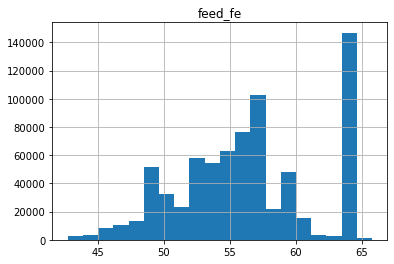

In [154]:
#check if different ore types or grades that are at plant.  
#definately should split the high grade material - 62%+
#split really low grade - 52% and less 
#could split hte middle section 52%+ to <62%

hist = df.hist("feed_fe", bins=20)


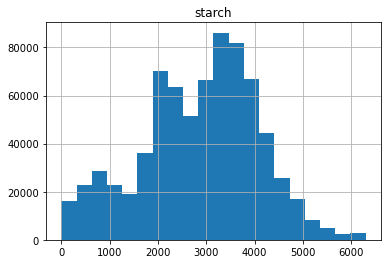

In [155]:
hist = df2.hist("starch", bins=20)

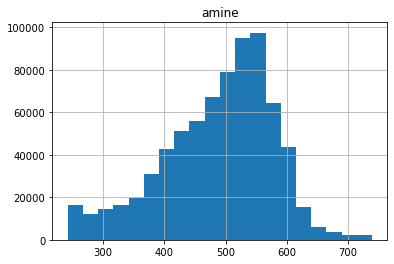

In [156]:
hist = df2.hist("amine", bins=20)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001594004FD90>]],
      dtype=object)

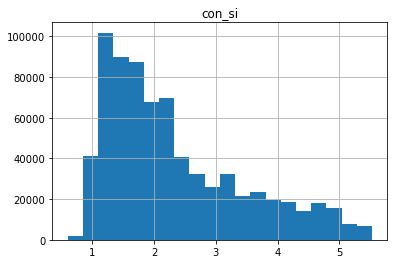

In [157]:
df2.hist("con_si", bins=20)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000015AB16DA7C0>]],
      dtype=object)

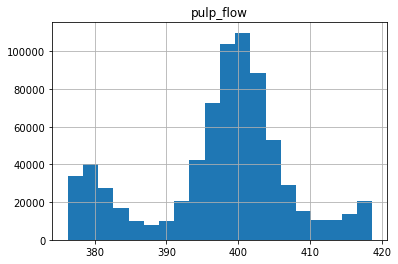

In [158]:
df2.hist("pulp_flow", bins=20)
#this seems to follow the fe a bit!

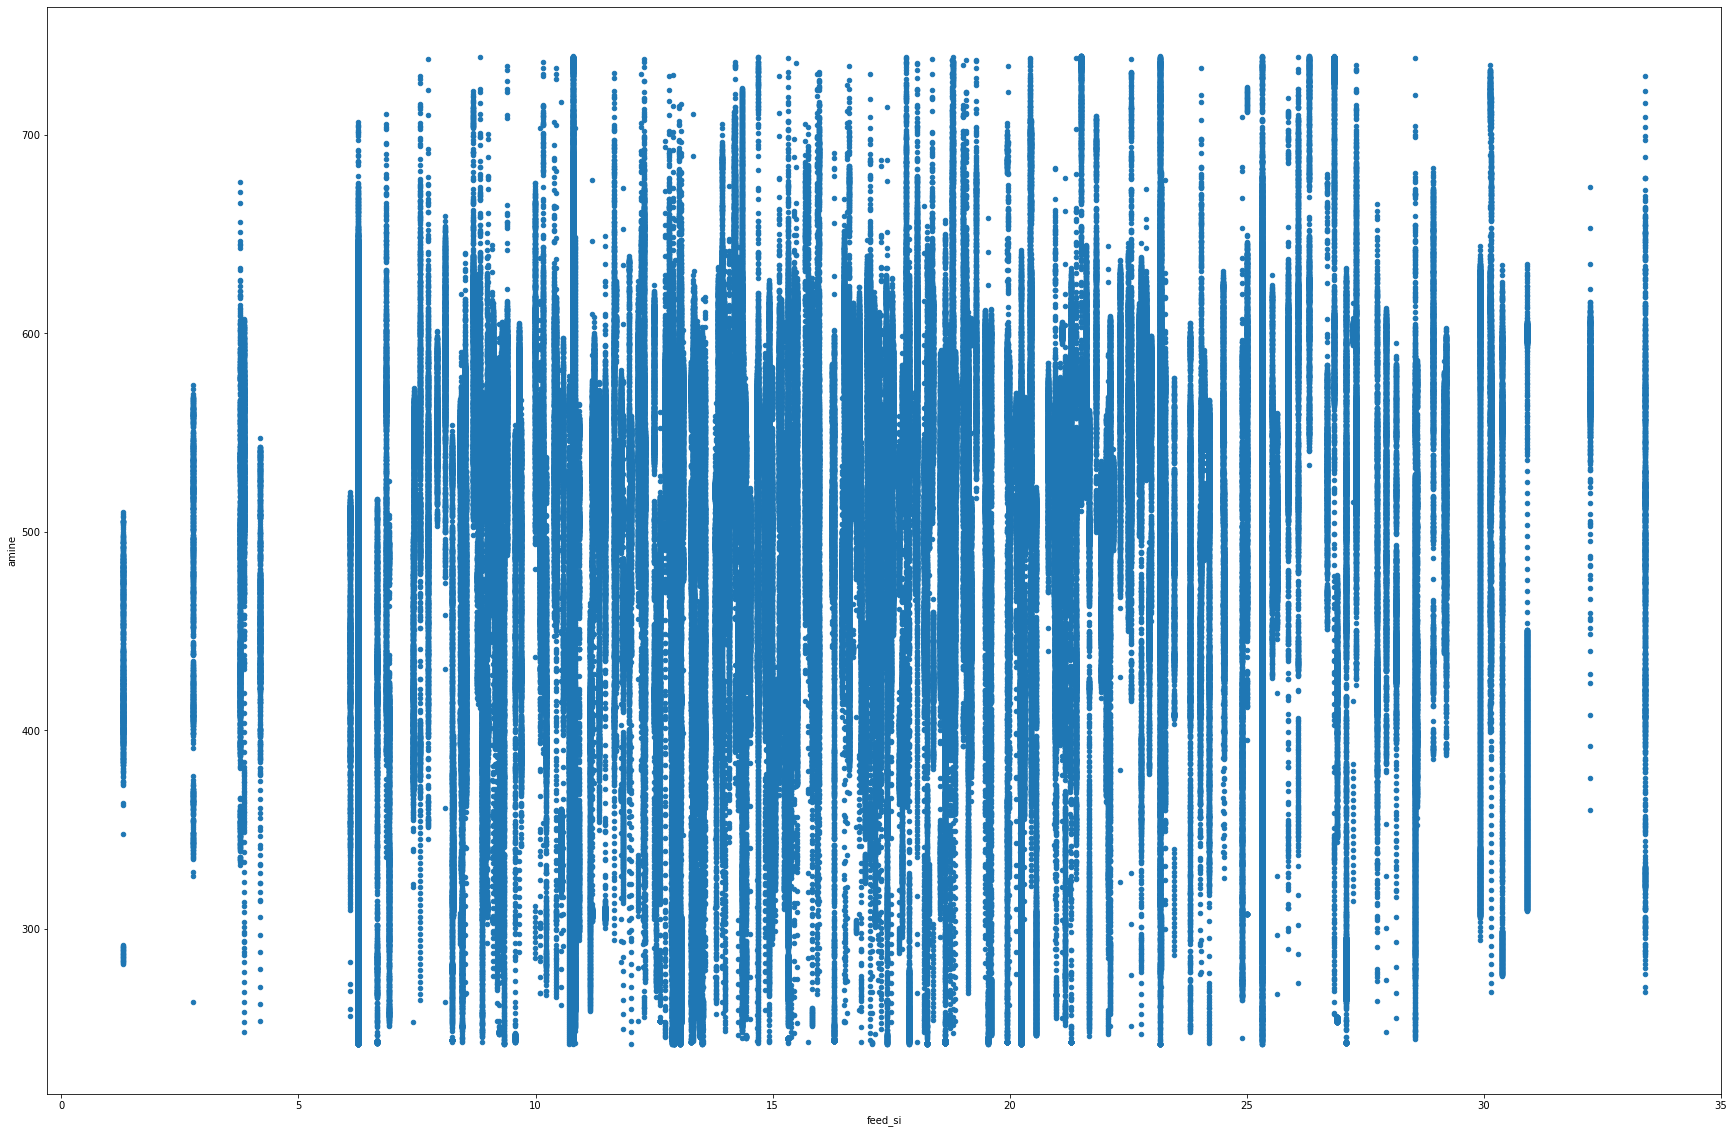

In [159]:
#less of a relationship than I thought 
scatter = df2.plot.scatter(y = "amine", x = "feed_si", figsize = (30,20))

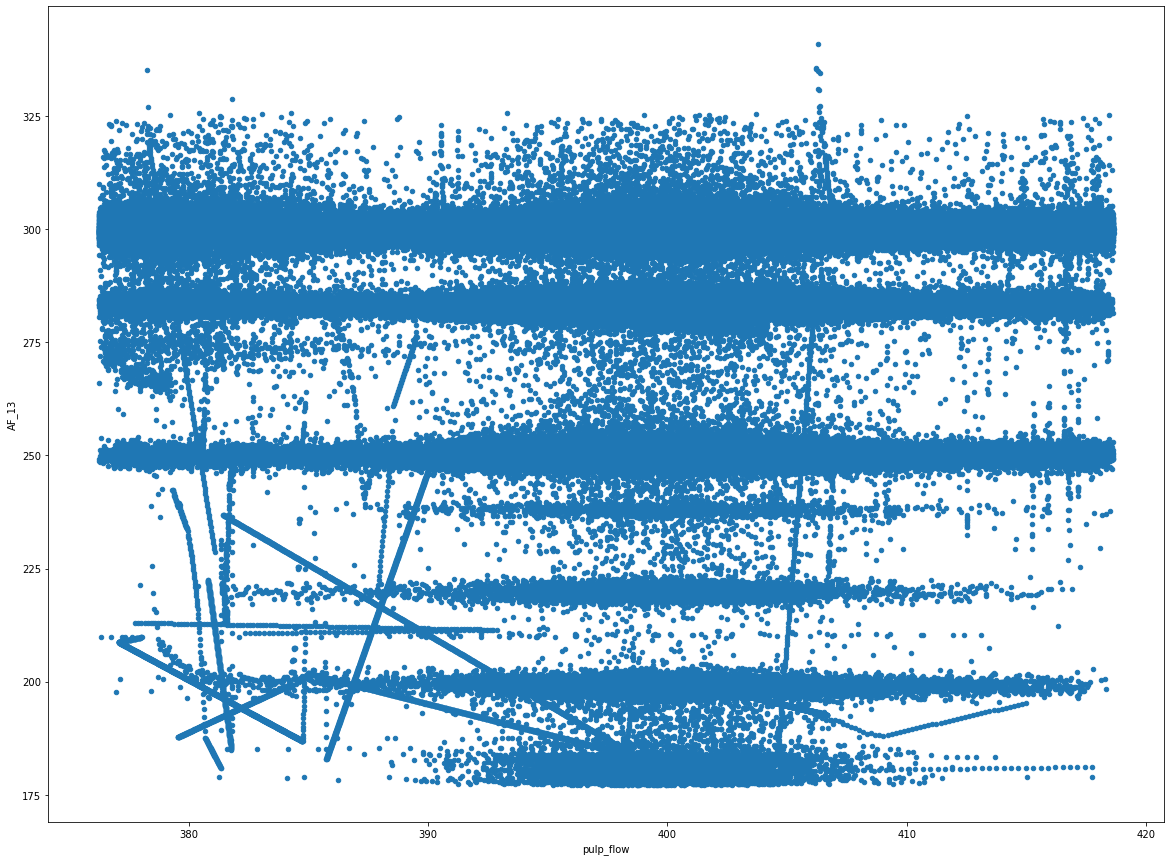

In [160]:
scatter = df2.plot.scatter("pulp_flow", "AF_13", figsize = (20,15))

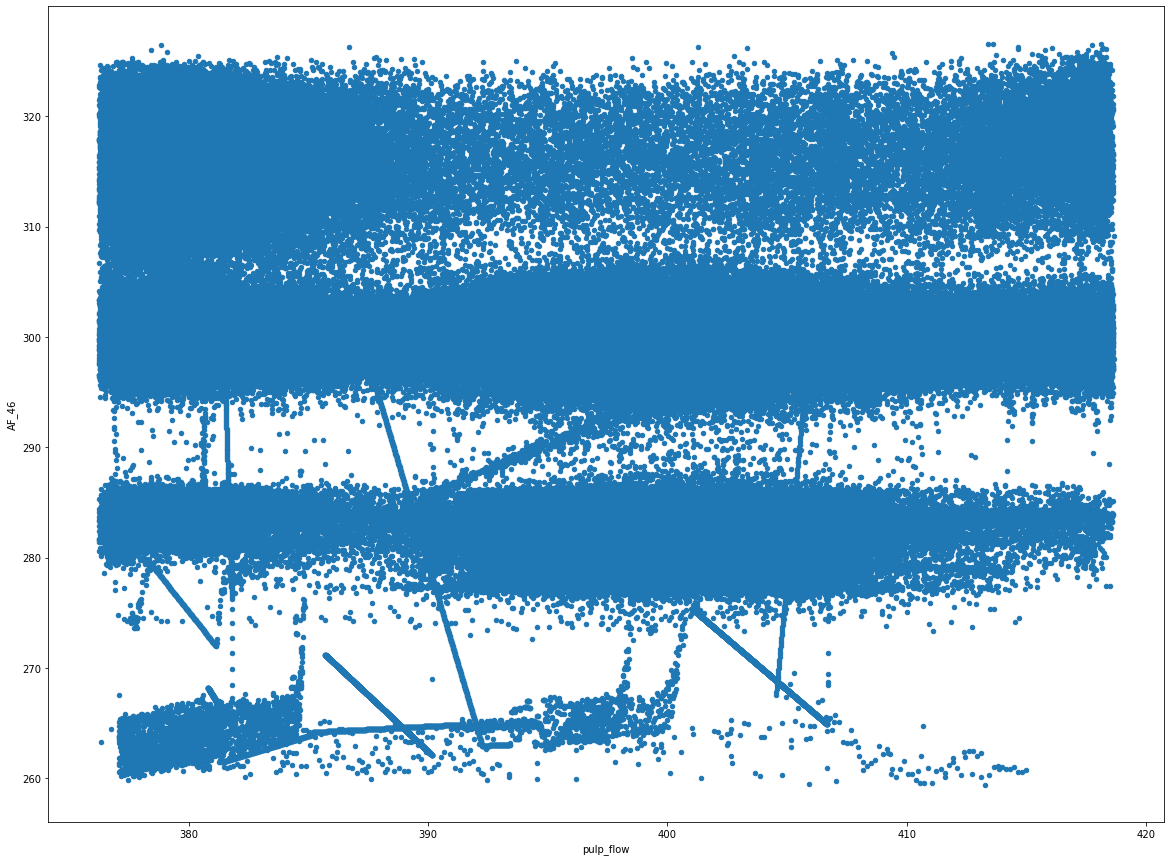

In [161]:
scatter = df2.plot.scatter("pulp_flow", "AF_46", figsize = (20,15))

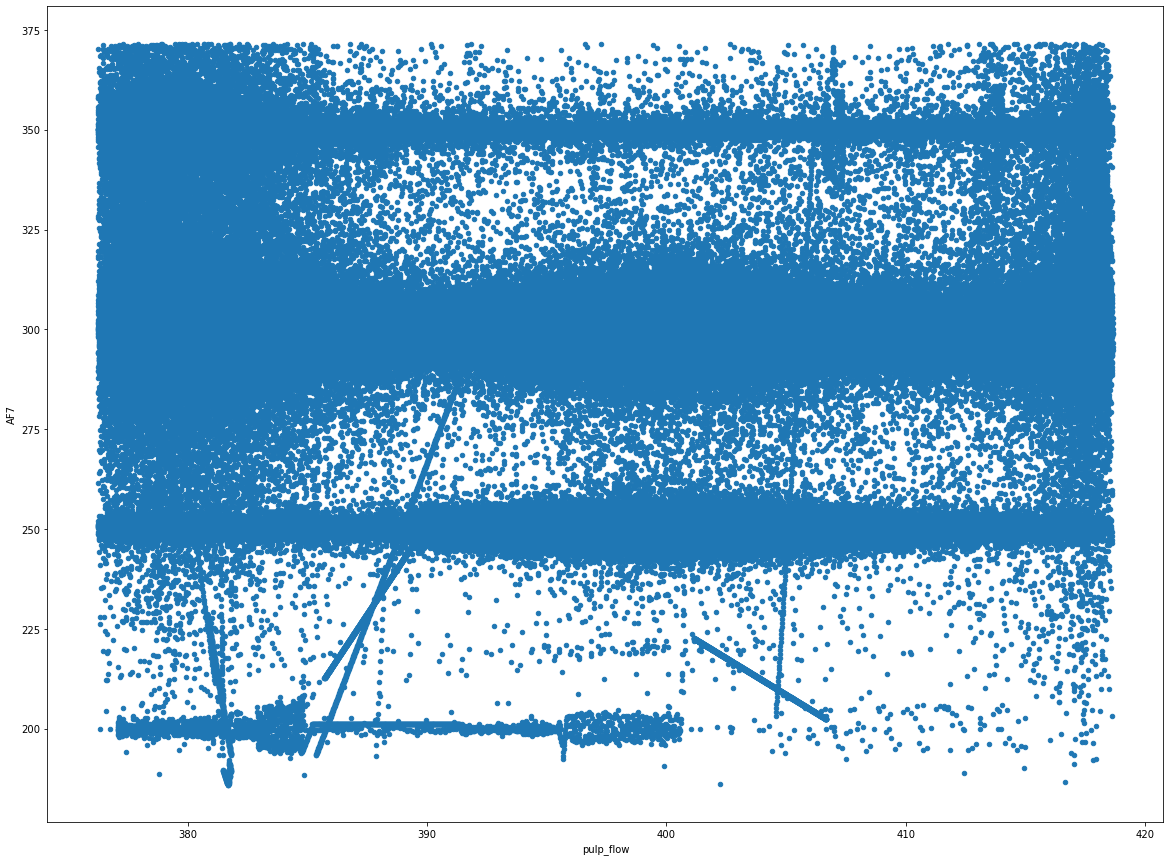

In [162]:
scatter = df2.plot.scatter("pulp_flow", "AF7", figsize = (20,15))

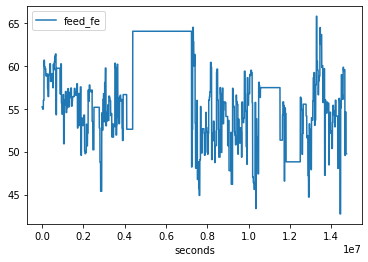

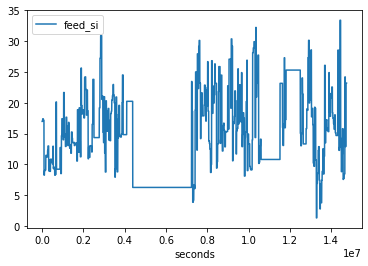

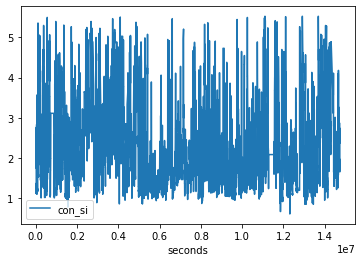

In [163]:
#why does the fe in feed not change for large chunks of time?  Maybe take out some of this data
df.plot.line("seconds", "feed_fe")
df.plot.line("seconds", "feed_si")
df.plot.line("seconds", "con_si")

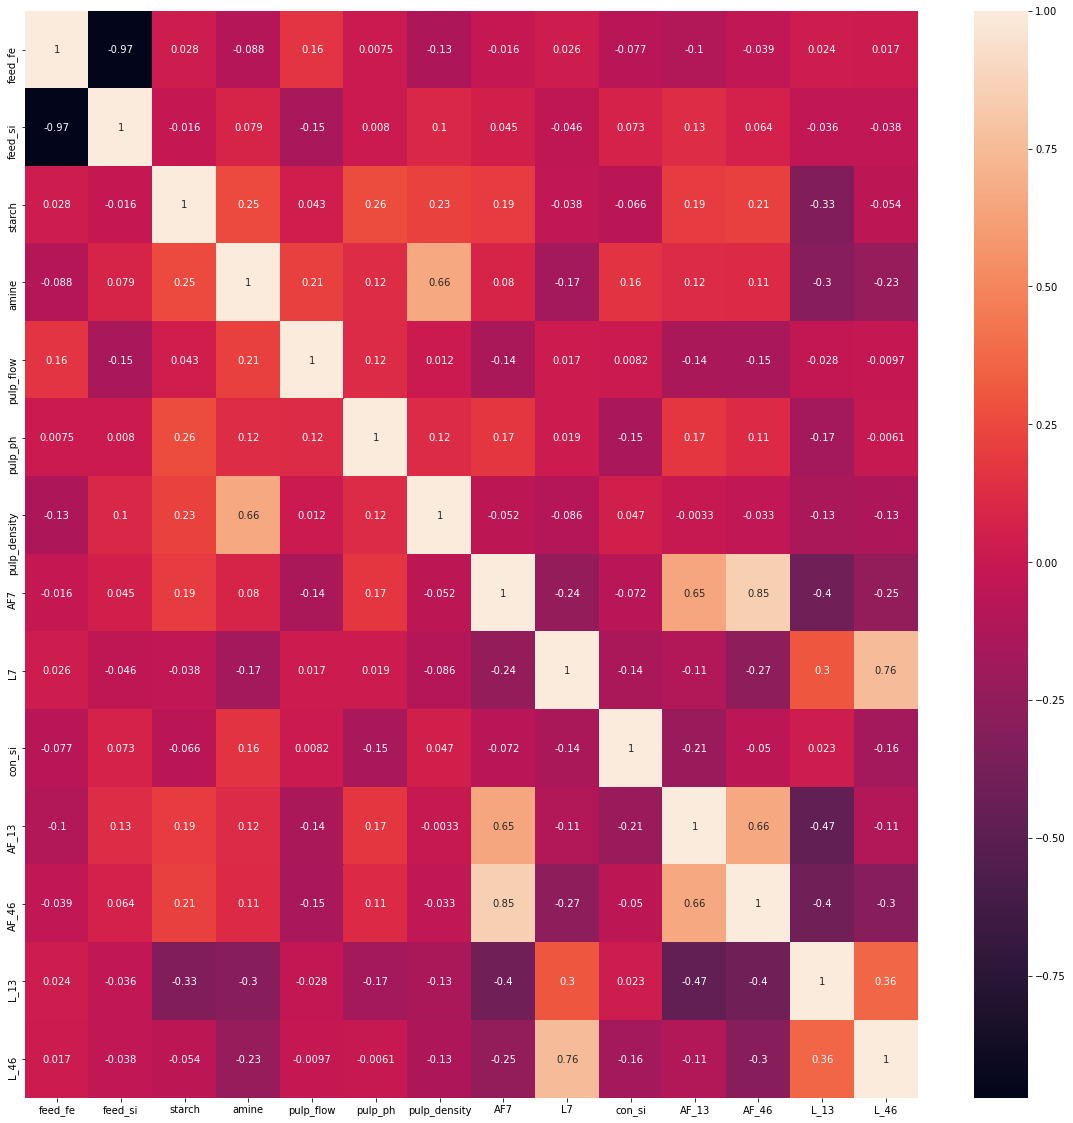

In [164]:
#heat map overall 
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(df2.corr(), annot = True, ax = ax)

In [176]:
#create three dataframes for starting feed grade 

low_grade = df2.loc[df2["feed_fe"]<50]
medium_grade= df2.loc[(df2["feed_fe"]>=50) & (df2["feed_fe"]<=63)]
high_grade= df2.loc[df2["feed_fe"]>63]


In [166]:
high_grade.count()

feed_fe         147960
feed_si         147960
starch          147960
amine           147960
pulp_flow       147960
pulp_ph         147960
pulp_density    147960
AF7             147960
L7              147960
con_si          147960
AF_13           147960
AF_46           147960
L_13            147960
L_46            147960
dtype: int64

In [167]:
low_grade.count()

feed_fe         124560
feed_si         124560
starch          124560
amine           124560
pulp_flow       124560
pulp_ph         124560
pulp_density    124560
AF7             124560
L7              124560
con_si          124560
AF_13           124560
AF_46           124560
L_13            124560
L_46            124560
dtype: int64

In [168]:
medium_grade.count()

feed_fe         464933
feed_si         464933
starch          464933
amine           464933
pulp_flow       464933
pulp_ph         464933
pulp_density    464933
AF7             464933
L7              464933
con_si          464933
AF_13           464933
AF_46           464933
L_13            464933
L_46            464933
dtype: int64

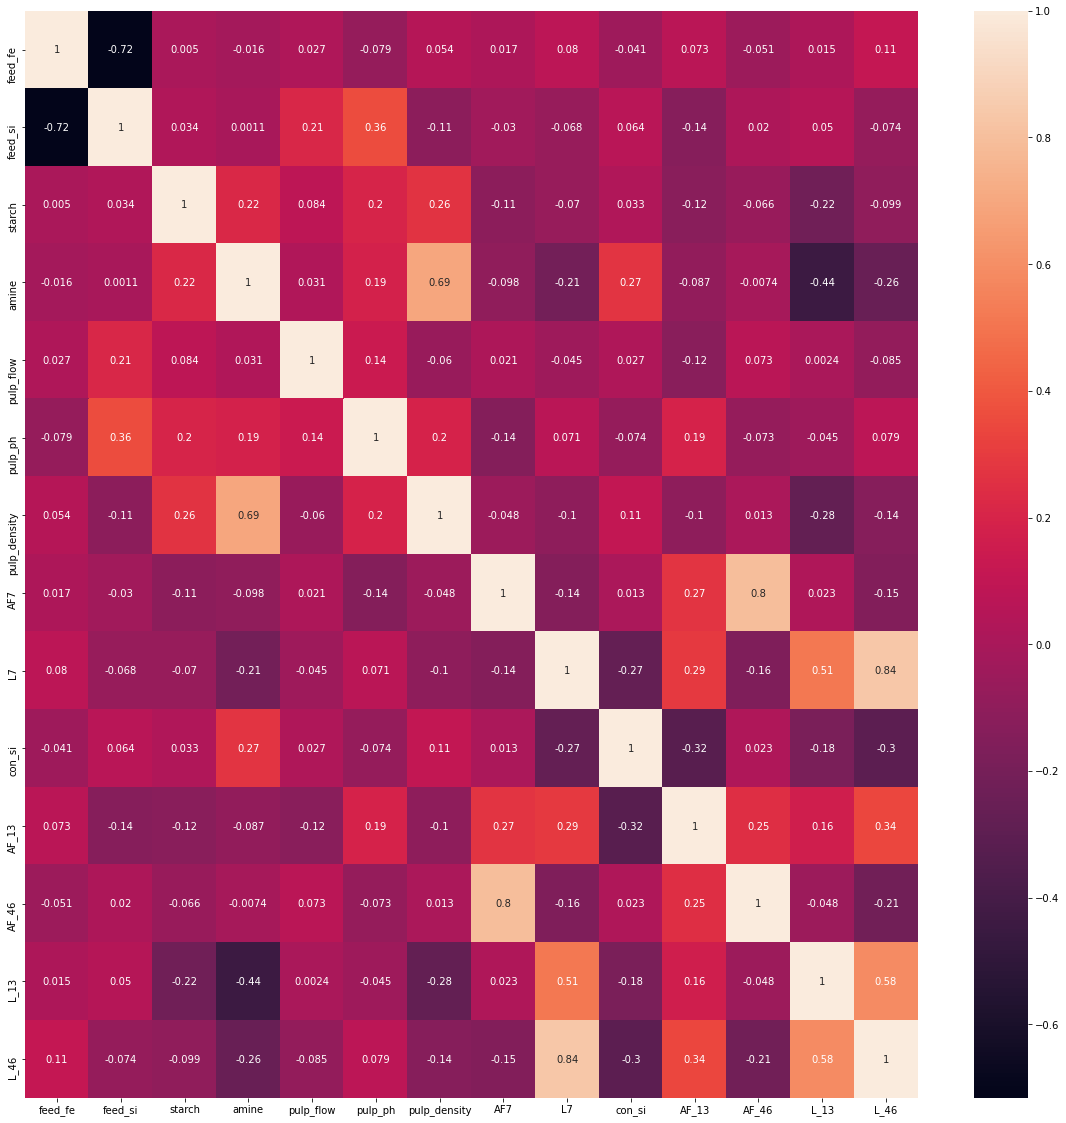

In [169]:
#heat maps with new dataframe
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(high_grade.corr(), annot = True, ax = ax)

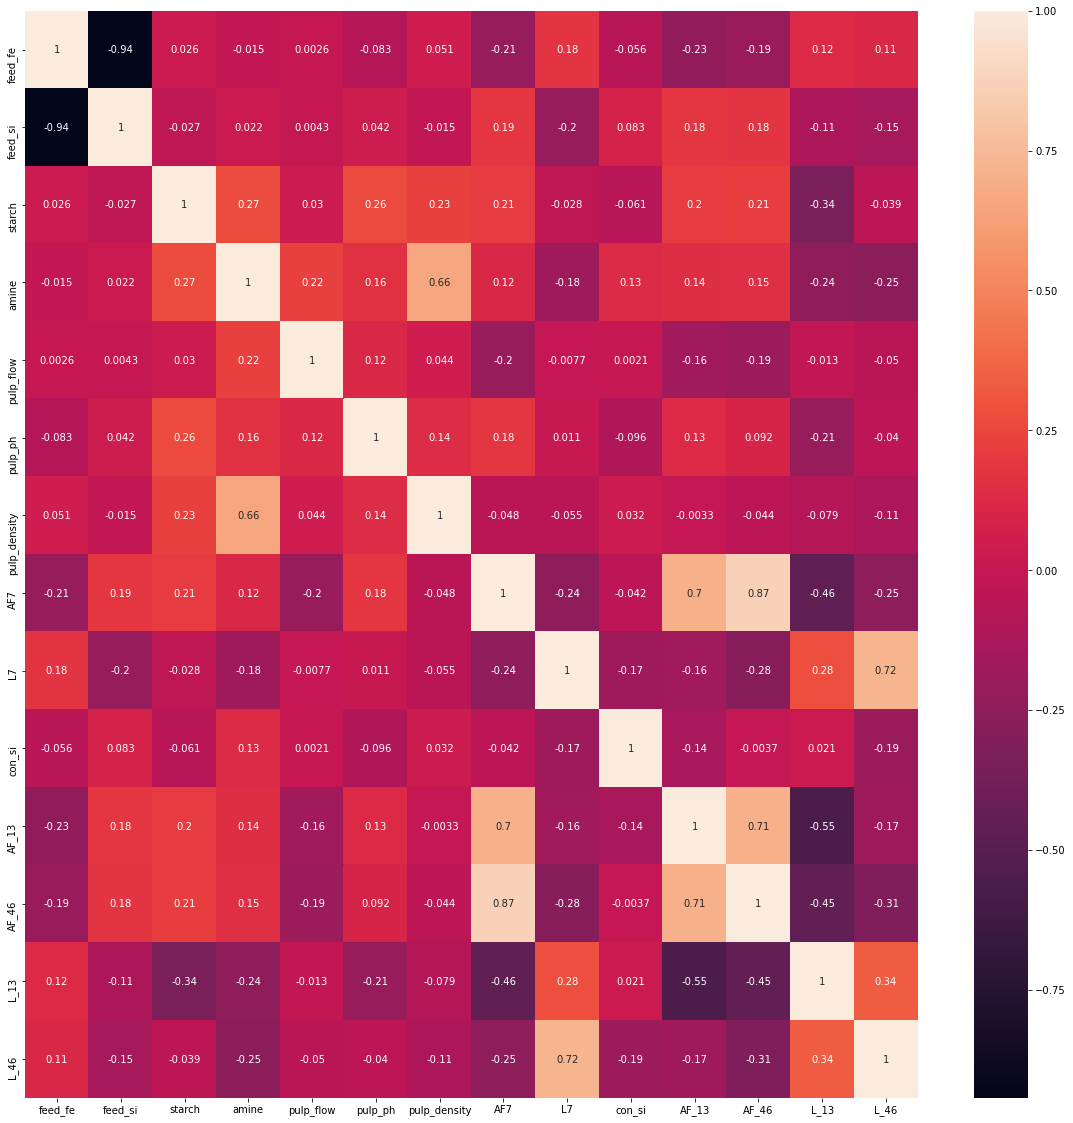

In [170]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(medium_grade.corr(), annot = True, ax = ax)

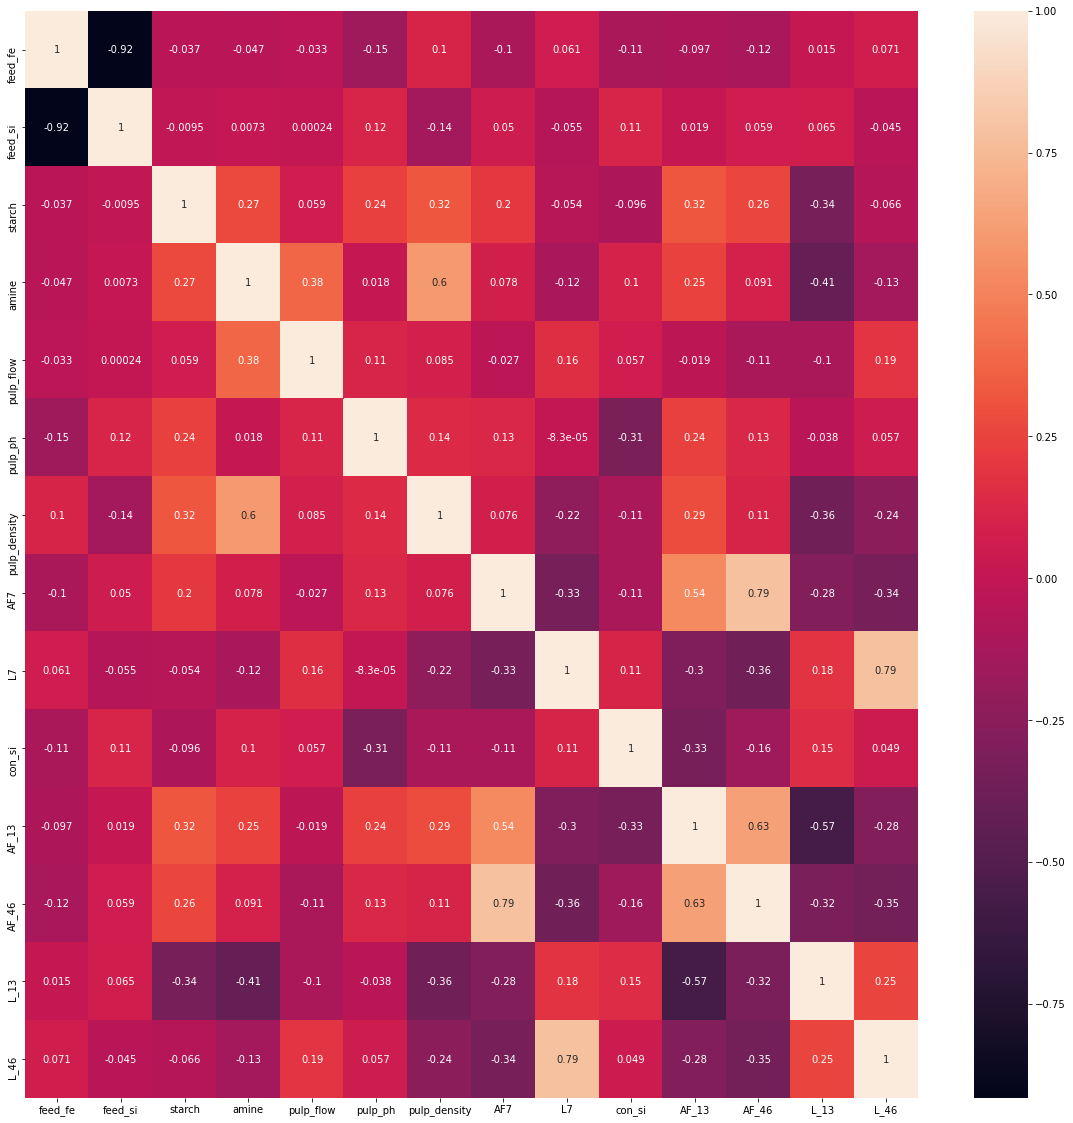

In [171]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(low_grade.corr(), annot = True, ax = ax)

In [172]:


x = df2[['feed_fe','feed_si', 'pulp_flow','pulp_ph', 'pulp_density', 'AF7', "L7", 
        'AF_13', 'AF_46', 'L_13', 'L_46', 'amine', 'starch']]
y = df2['con_si']

x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=0,test_size=0.2)


#linear regression 

lr=LinearRegression()
lr.fit(x_train,y_train)
pred_1=lr.predict(x_test)
score_1=r2_score(y_test,pred_1)

print(score_1)


0.1391351853893975


In [179]:
x = high_grade[['feed_fe','feed_si', 'pulp_flow','pulp_ph', 'pulp_density', 'AF7', "L7", 
        'AF_13', 'AF_46', 'L_13', 'L_46', 'amine', 'starch']]
y = high_grade['con_si']

x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=0,test_size=0.2)


#linear regression 

lr=LinearRegression()
lr.fit(x_train,y_train)
pred_1=lr.predict(x_test)
score_1=r2_score(y_test,pred_1)

print(score_1)

0.21376924698081368


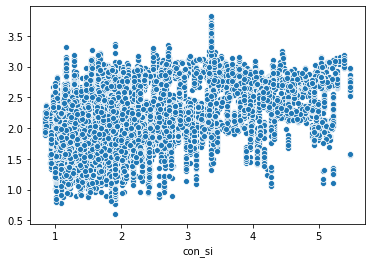

In [181]:
sns.scatterplot(x=y_test,y=pred_1)

In [177]:
x = low_grade[['feed_fe','feed_si', 'pulp_flow','pulp_ph', 'pulp_density', 'AF7', "L7", 
        'AF_13', 'AF_46', 'L_13', 'L_46', 'amine', 'starch']]
y = low_grade['con_si']

x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=0,test_size=0.2)


#linear regression 

lr=LinearRegression()
lr.fit(x_train,y_train)
pred_1=lr.predict(x_test)
score_1=r2_score(y_test,pred_1)

print(score_1)

0.30122301580895494


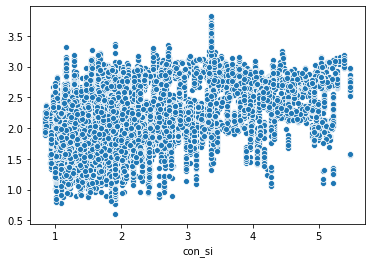

In [180]:
sns.scatterplot(x=y_test,y=pred_1)

In [178]:
x = medium_grade[['feed_fe','feed_si', 'pulp_flow','pulp_ph', 'pulp_density', 'AF7', "L7", 
        'AF_13', 'AF_46', 'L_13', 'L_46', 'amine', 'starch']]
y = medium_grade['con_si']

x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=0,test_size=0.2)


#linear regression 

lr=LinearRegression()
lr.fit(x_train,y_train)
pred_1=lr.predict(x_test)
score_1=r2_score(y_test,pred_1)

print(score_1)

0.10930210114394612
